# Q1

In [177]:
lr = 0.3
beta1 = 0.9
beta2 = 0.999
epislon = 0
theta = 0
m = 0
v = 0
t = 0

In [178]:
ans = []

for i in range(20):
    t =t + 1
    if theta<1:
        g = -1
    else:
        g = 1
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * (g * g )
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    theta -= lr * m_hat / (v_hat ** 0.5 + epislon)
    
    
    ans.append(theta-1)
print('Max h = ',max(ans))

Max h =  0.4101842951299657


# Q2

# latent dimension = 2

In [9]:
import keras
from keras import layers

# This is the size of our encoded representations
original_dim = 784
intermediate_dim = 64
latent_dim = 2

# This is our input image
input_img = keras.Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
hidden = layers.Dense(intermediate_dim, activation='relu')(input_img)
#hidden = layers.Dense(256, activation='relu')(hidden)

z_mean = layers.Dense(latent_dim)(hidden)
z_log_sigma = layers.Dense(latent_dim)(hidden)


In [10]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [11]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
#x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
# Create the decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')


# instantiate VAE model
outputs = decoder(encoder(input_img)[2])
autoencoder = keras.Model(input_img, outputs, name='autoencoder')


In [12]:
# use L1-norm loss function and adam optimizer
reconstruction_loss = keras.losses.mean_absolute_error(input_img, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
autoencoder_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder.add_loss(autoencoder_loss)
autoencoder.compile(optimizer='adam')

In [13]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.fit(x_train, x_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 122.2660 - val_loss: 92.5679
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 87.7264 - val_loss: 82.7371
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 80.9071 - val_loss: 79.6997
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 78.9280 - val_loss: 78.3117
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 77.7853 - val_loss: 77.3326
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 77.0555 - val_loss: 76.8516
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 76.5652 - val_loss: 76.4230
Epoch 8/20
469/469 [==============================] - 1s 3ms/step - loss: 76.1472 - val_loss: 75.9790
Epoch 9/20
469/469 [==============================] - 1s 2ms/step - loss: 75.8489 - val_loss: 75.8191
Epoch 10/20
469/469 [==============================] - 1s 2ms/step - loss: 75.575

In [15]:
decoded_imgs = autoencoder.predict(x_test)

1:  [array([[ 0.4695883 , -0.5614274 ],
       [-0.02485718,  0.30915082],
       [-0.8462925 , -0.8768909 ],
       ...,
       [ 0.44861156, -0.6596706 ],
       [-0.3837896 , -0.6418538 ],
       [ 1.0777134 ,  0.48356354]], dtype=float32), array([[-0.97154   , -0.9364025 ],
       [-0.7034005 , -0.80052096],
       [-0.7868726 , -0.5958683 ],
       ...,
       [-0.6945413 , -0.67044675],
       [-0.55359435, -0.50768226],
       [-0.60484785, -0.8325777 ]], dtype=float32), array([[ 0.46568882, -0.5786906 ],
       [-0.08601995,  0.34237653],
       [-0.8547781 , -0.8456953 ],
       ...,
       [ 0.45748115, -0.53401923],
       [-0.46895435, -0.6911256 ],
       [ 1.0746382 ,  0.5277003 ]], dtype=float32)]


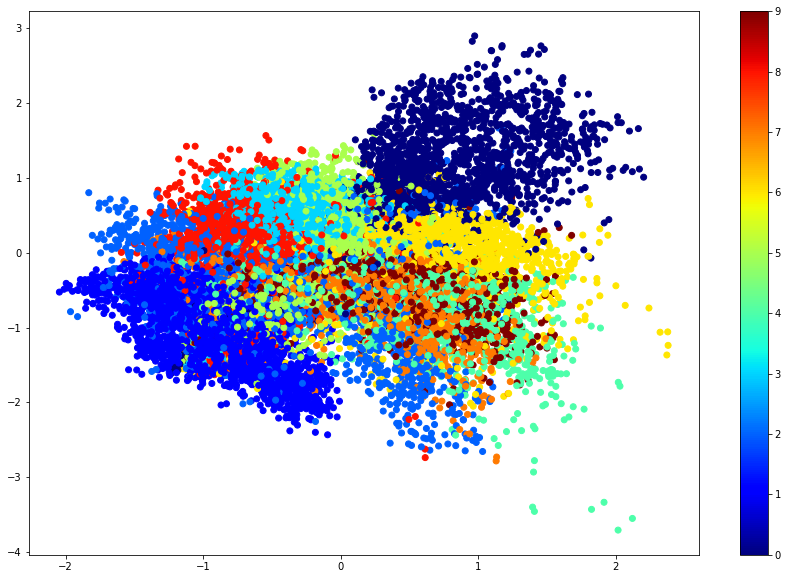

In [6]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=128)
print('1: ',x_test_encoded)
plt.figure(figsize=(15, 10))
# x_test_encoded =  np.array(x_test_encoded)
# x_test_encoded =  np.array(x_test_encoded)
# print('2: ',x_test_encoded)
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1],c=y_test,cmap="jet" )
plt.scatter(x_test_encoded[1][:, 0], x_test_encoded[1][:, 1],c=y_test,cmap="jet" )
plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1],c=y_test,cmap="jet" )
plt.colorbar()
plt.show()

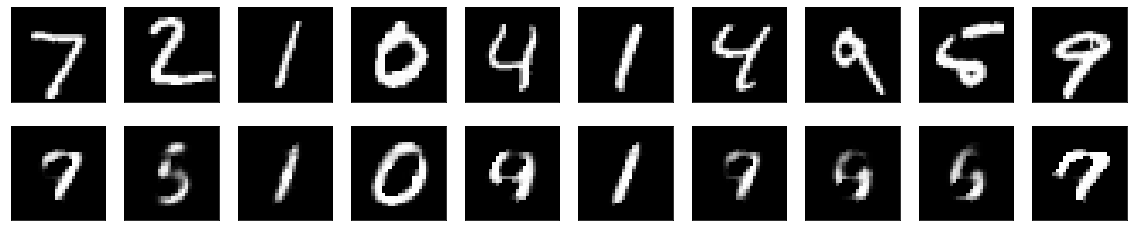

In [16]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# latent dimension = 16

In [17]:
import keras
from keras import layers

# This is the size of our encoded representations
original_dim = 784
intermediate_dim = 64
latent_dim = 16

# This is our input image
input_img = keras.Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
hidden = layers.Dense(intermediate_dim, activation='relu')(input_img)

z_mean = layers.Dense(latent_dim)(hidden)
z_log_sigma = layers.Dense(latent_dim)(hidden)


In [18]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [19]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)
# Create the decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')


# instantiate VAE model
outputs = decoder(encoder(input_img)[2])
autoencoder = keras.Model(input_img, outputs, name='autoencoder')


In [20]:
reconstruction_loss = keras.losses.mean_absolute_error(input_img, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
autoencoder_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder.add_loss(autoencoder_loss)
autoencoder.compile(optimizer='adam')

In [21]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.fit(x_train, x_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 106.7649 - val_loss: 73.2829
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 66.5695 - val_loss: 61.0106
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 58.0485 - val_loss: 54.5808
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 52.9154 - val_loss: 49.8937
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 49.2328 - val_loss: 47.0117
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 46.8939 - val_loss: 45.4608
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 45.4640 - val_loss: 44.1334
Epoch 8/20
469/469 [==============================] - 1s 2ms/step - loss: 44.4352 - val_loss: 43.4285
Epoch 9/20
469/469 [==============================] - 1s 2ms/step - loss: 43.7215 - val_loss: 42.6756
Epoch 10/20
469/469 [==============================] - 1s 2ms/step - loss: 43.149

In [22]:
decoded_imgs = autoencoder.predict(x_test)

nx:  3
ny:  10000
nz:  16


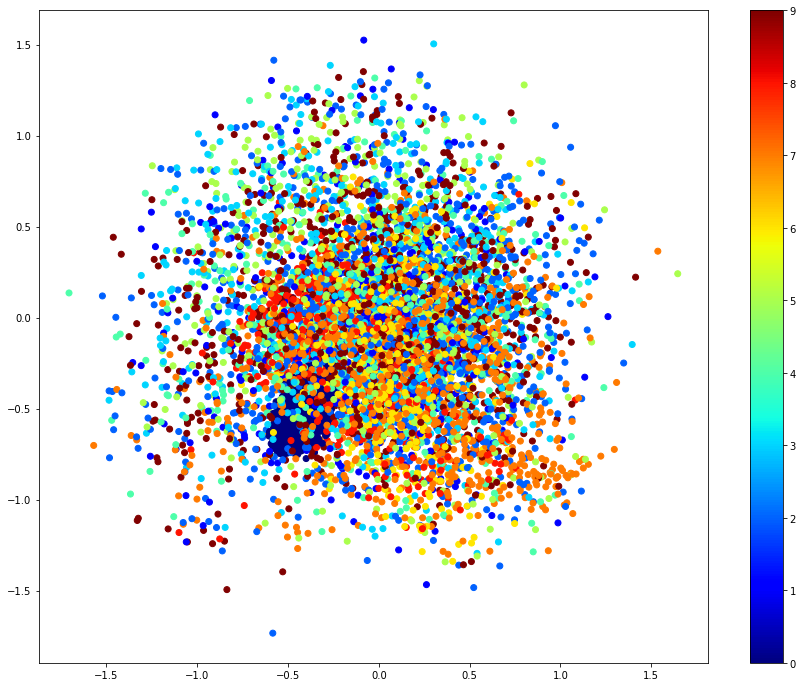

In [23]:
from sklearn.cluster import KMeans

x_test_encoded = encoder.predict(x_test, batch_size=128)
nx, ny, nz = np.array(x_test_encoded).shape
print('nx: ',nx)
print('ny: ',ny)
print('nz: ',nz)
temp_encoded = np.array(x_test_encoded).reshape((ny,nx*nz))

km = KMeans(n_clusters=10).fit(temp_encoded)
plt.figure(figsize=(15, 12))
plt.scatter(temp_encoded[:, 0], temp_encoded[:, 1],c=km.labels_,cmap="jet")
plt.colorbar()
plt.show()



# plt.figure(figsize=(15, 12))
# plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1],c=y_test,cmap="jet")
# plt.scatter(x_test_encoded[1][:, 0], x_test_encoded[1][:, 1],c=y_test,cmap="jet")
# plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1],c=y_test,cmap="jet")
# plt.colorbar()
# plt.show()

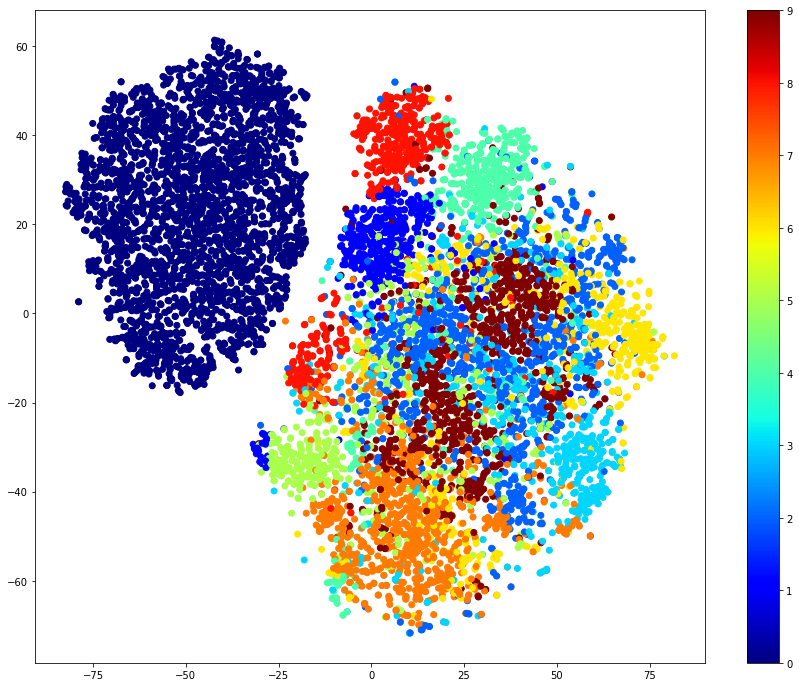

In [24]:
from sklearn.manifold import TSNE
import tensorflow as tf

tsne = TSNE().fit_transform(temp_encoded)
plt.figure(figsize=(15, 12))
plt.scatter(x = tsne[:, 0], y=tsne[:, 1],c=km.labels_,cmap="jet")
plt.colorbar()
plt.show()

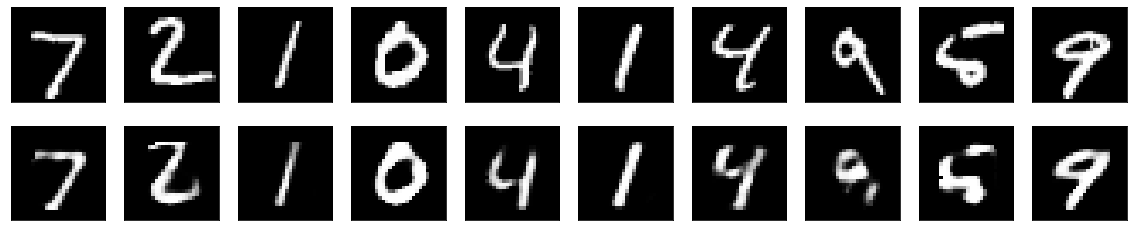

In [25]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# latent dimension = 256

In [26]:
import keras
from keras import layers

# This is the size of our encoded representations
original_dim = 784
intermediate_dim = 64
latent_dim = 256

# This is our input image
input_img = keras.Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
hidden = layers.Dense(intermediate_dim, activation='relu')(input_img)

z_mean = layers.Dense(latent_dim)(hidden)
z_log_sigma = layers.Dense(latent_dim)(hidden)


In [27]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [28]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)
# Create the decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')


# instantiate VAE model
outputs = decoder(encoder(input_img)[2])
autoencoder = keras.Model(input_img, outputs, name='autoencoder')


In [29]:
reconstruction_loss = keras.losses.mean_absolute_error(input_img, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
autoencoder_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder.add_loss(autoencoder_loss)
autoencoder.compile(optimizer='adam')

In [30]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.fit(x_train, x_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 105.4184 - val_loss: 76.2953
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 68.3746 - val_loss: 62.5859
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 59.5022 - val_loss: 55.2959
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 52.7817 - val_loss: 49.6874
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 48.6787 - val_loss: 46.7850
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 46.5305 - val_loss: 44.9650
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 45.0018 - val_loss: 43.5194
Epoch 8/20
469/469 [==============================] - 1s 3ms/step - loss: 43.6011 - val_loss: 42.5376
Epoch 9/20
469/469 [==============================] - 1s 3ms/step - loss: 42.5968 - val_loss: 41.4123
Epoch 10/20
469/469 [==============================] - 1s 3ms/step - loss: 41.749

In [31]:
decoded_imgs = autoencoder.predict(x_test)

nx:  3
ny:  10000
nz:  256


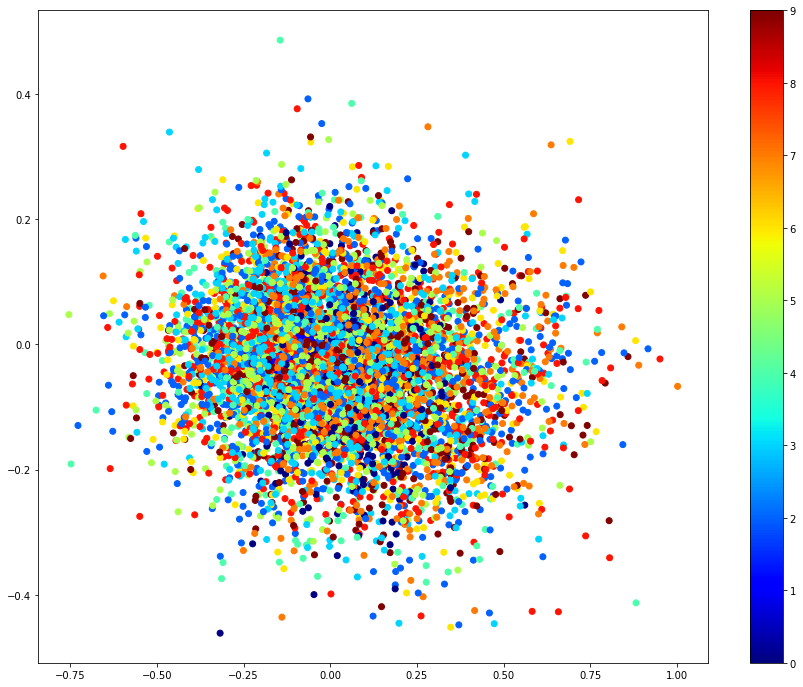

In [32]:
from sklearn.cluster import KMeans

x_test_encoded = encoder.predict(x_test, batch_size=128)
nx, ny, nz = np.array(x_test_encoded).shape
print('nx: ',nx)
print('ny: ',ny)
print('nz: ',nz)
temp_encoded = np.array(x_test_encoded).reshape((ny,nx*nz))

km = KMeans(n_clusters=10).fit(temp_encoded)
plt.figure(figsize=(15, 12))
plt.scatter(temp_encoded[:, 0], temp_encoded[:, 1],c=km.labels_,cmap="jet")
plt.colorbar()
plt.show()



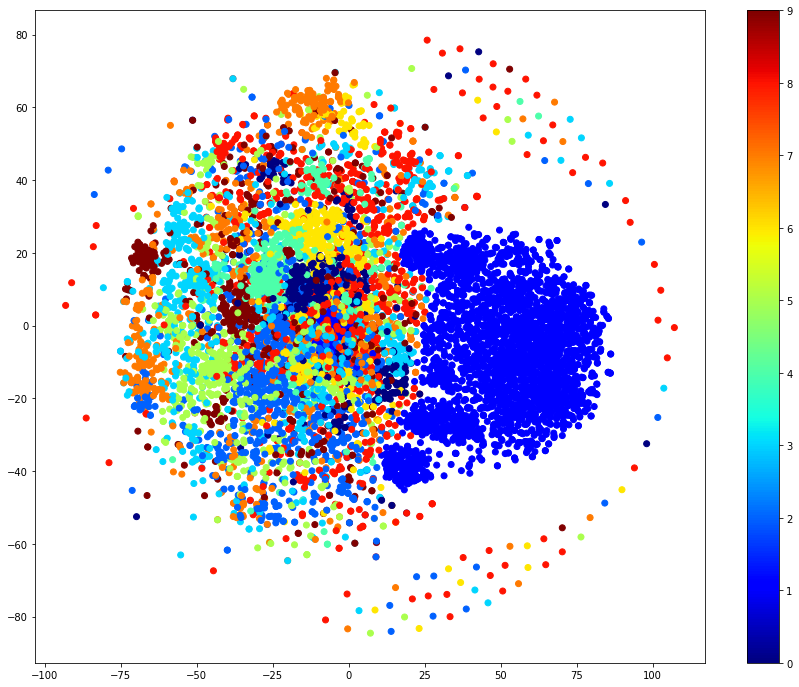

In [33]:
from sklearn.manifold import TSNE
import tensorflow as tf

tsne = TSNE().fit_transform(temp_encoded)
plt.figure(figsize=(15, 12))
plt.scatter(x = tsne[:, 0], y=tsne[:, 1],c=km.labels_,cmap="jet")
plt.colorbar()
plt.show()

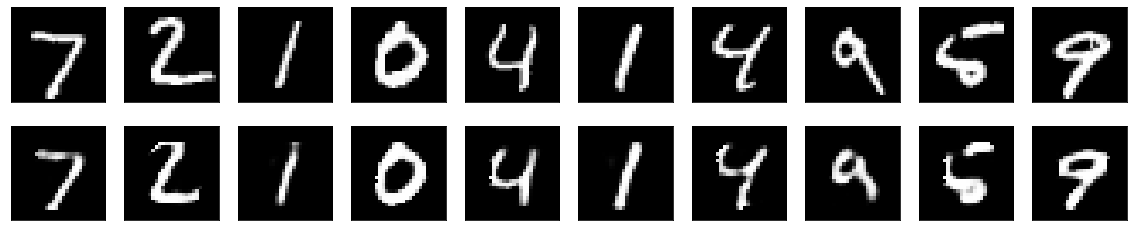

In [34]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [35]:
ooo = 

SyntaxError: invalid syntax (<ipython-input-35-78ccf1f03e4b>, line 1)

# Q2

## dis_net

In [36]:
# import keras
# from keras import layers

# # This is the size of our encoded representations
# encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# # This is our input image
# input_img = keras.Input(shape=(784,))
# # "encoded" is the encoded representation of the input
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# # "decoded" is the lossy reconstruction of the input
# decoded = layers.Dense(784, activation='sigmoid')(encoded)

# # This model maps an input to its reconstruction
# autoencoder = keras.Model(input_img, decoded)

In [37]:
# # This model maps an input to its encoded representation
# encoder = keras.Model(input_img, encoded)

# # This is our encoded (32-dimensional) input
# encoded_input = keras.Input(shape=(encoding_dim,))
# # Retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # Create the decoder model
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# Add Gaussian Noise

In [44]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


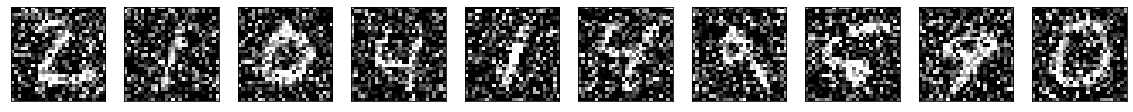

In [45]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Reconstruction

In [46]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

In [47]:
print(x_train_noisy.shape)
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128)
#                 shuffle=True,
#                 validation_data=(x_test_noisy, x_test))

(60000, 28, 28, 1)
Epoch 1/10
469/469 [==============================] - 54s 115ms/step - loss: 0.1367
Epoch 2/10
469/469 [==============================] - 52s 111ms/step - loss: 0.1307
Epoch 3/10
469/469 [==============================] - 53s 112ms/step - loss: 0.1307
Epoch 4/10
469/469 [==============================] - 53s 113ms/step - loss: 0.1307
Epoch 5/10
469/469 [==============================] - 52s 110ms/step - loss: 0.1307
Epoch 6/10
469/469 [==============================] - 52s 111ms/step - loss: 0.1307
Epoch 7/10
469/469 [==============================] - 53s 113ms/step - loss: 0.1307
Epoch 8/10
469/469 [==============================] - 53s 114ms/step - loss: 0.1307
Epoch 9/10
469/469 [==============================] - 52s 112ms/step - loss: 0.1307
Epoch 10/10
469/469 [==============================] - 54s 116ms/step - loss: 0.1307


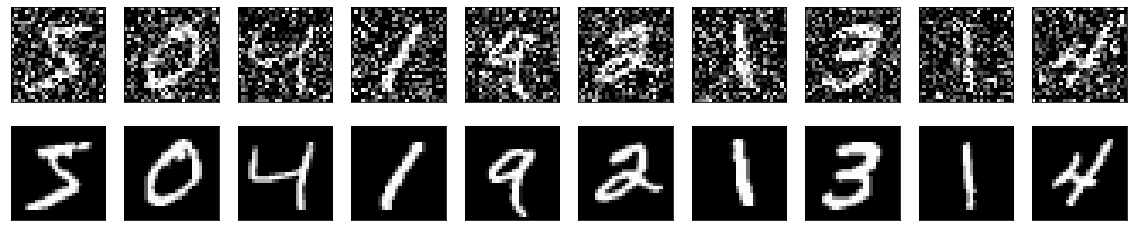

In [50]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test_noisy)


n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()